<a href="https://colab.research.google.com/github/MurphLaws/Exp/blob/main/Group_Influence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
import numpy as np
import random
from matplotlib import pyplot as plt, cm, colors
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
from itertools import chain
import itertools
import tensorflow as tf
from sklearn.model_selection import train_test_split
from operator import itemgetter
tf.autograph.set_verbosity(0)
from tqdm import tqdm
import os
import glob
from google.colab import files
from matplotlib.ticker import FixedFormatter
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import bisplrep, bisplev
from scipy.ndimage import gaussian_filter
from collections import namedtuple
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from itertools import compress
import seaborn as sns
from scipy.stats import spearmanr
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.lines import Line2D
from scipy.spatial import KDTree
from more_itertools import flatten


X1        X2  Label
0 -0.001461 -0.657357    0.0
1  0.480067 -2.240576    0.0
2 -0.048678 -0.573525    0.0
3  1.519183 -1.040114    0.0
4  0.038773  1.612674    0.0

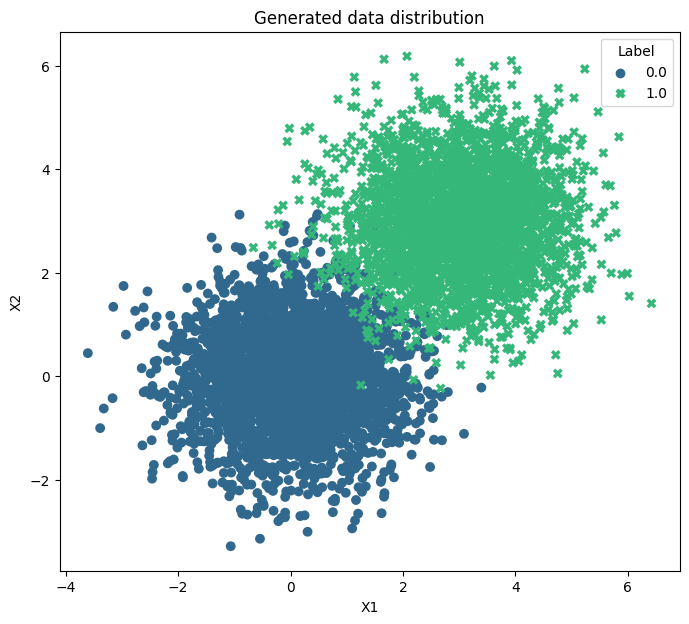

In [151]:
random.seed(2349324)
np.random.seed(2349324)
tf.random.set_seed(2349324)


# Create dataset composed of teo points clusters with generated with a bivariate gaussian distribution with mean [0,0] and [4,4]
# and equal covariance matrices.

def create_data(n):
    mean1 = [0,0]
    covmat = [[1, 0], [0, 1]]
    cov  = covmat
    x1_1, x2_1 = np.random.multivariate_normal(mean1, cov, int(n/2)).T

    mean2 = [3,3]
    cov  = covmat
    x1_2, x2_2 = np.random.multivariate_normal(mean2, cov, int(n/2)).T


    pts1 = list(zip(x1_1, x2_1,itertools.repeat(0)))
    pts2 = list(zip(x1_2, x2_2,itertools.repeat(1)))

    return pd.DataFrame(np.concatenate((pts1,pts2),axis=0), columns = ["X1", "X2", "Label"])


interleaved  = create_data(6000)


plt.figure(figsize=(8,7))
sns.scatterplot(data=interleaved, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=50, linewidth=0).set(title = 'Generated data distribution')
interleaved.head()

In [152]:
Data = namedtuple('Data', ['x_train','x_test','y_train','y_test'])



def binary_cross_entropy(predictions, probabilities):
    binary_crossentropy = []
    for i in range(len(predictions)):
        b = predictions[i]
        p = probabilities[i][1]  # Assuming the probability of the positive class is at index 1

        # Calculate the binary crossentropy
        cross_entropy = -b * np.log(p) - (1 - b) * np.log(1 - p)
        binary_crossentropy.append(cross_entropy)

    return binary_crossentropy




def pred_and_prob(data):
    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)

    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    return y_pred, y_proba



def train_predict(data, output = 'loss'):

    np.random.seed(2349324)


    fan_avg = (data.x_train.shape[1] + 1) / 2  # Average of input and output dimensions
    limit = np.sqrt(6 / fan_avg)
    weights_init = np.random.uniform(low=-limit, high=limit, size=(data.x_train.shape[1],))

    logreg = LogisticRegression(solver='liblinear', random_state=2349324)
    logreg.coef_ = weights_init.reshape(1, -1)


    logreg.fit(data.x_train, data.y_train)

    y_pred  = logreg.predict(data.x_test)
    y_proba = logreg.predict_proba(data.x_test)

    if output == 'loss':
        return binary_cross_entropy(list(data.y_test), y_proba)
    else:
        coefficients = logreg.coef_
        intercept = logreg.intercept_
        boundary_slope = -coefficients[0, 0] / coefficients[0, 1]
        boundary_intercept = -intercept[0] / coefficients[0, 1]

        return(boundary_slope,boundary_intercept)


def leave_one_out_area(df, group_list):
    datasets = []
    for group in group_list:
        datasets.append((group, df.drop(group)))
    return datasets



def area_group_matrix(train, test, criteria_array):
    influences = []
    shr_x_train = train[['X1','X2']]
    shr_y_train = train['Label']
    shr_x_test  = test[['X1','X2']]
    shr_y_test  = test['Label']


    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))

    datasets = leave_one_out_area(shr_x_train, criteria_array)

    groups = [str(loo[0]) for loo in datasets]
    str_id_data = [((str(loo[0])),loo[1]) for loo in datasets]
    inf_matrix = pd.DataFrame(0, index=groups, columns=list(shr_x_test.index))

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[str(ds[0])] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    #AGM.drop(AGM[AGM.index.duplicated()])
    #df[~df.index.duplicated()]

    return inf_matrix[~inf_matrix.index.duplicated()]






X1        X2  Label
1231 -1.914409 -1.951685    0.0
2113 -1.918339 -1.926355    0.0
337  -2.183586 -1.682980    0.0
2279 -2.147121 -1.641747    0.0
1776 -2.077375 -1.608166    0.0
...        ...       ...    ...
3284  3.600277  4.124128    1.0
4281  3.673483  4.263857    1.0
5872  4.215941  3.638189    1.0
3318  3.642839  3.773219    1.0
5543  3.582345  4.075224    1.0

[400 rows x 3 columns]

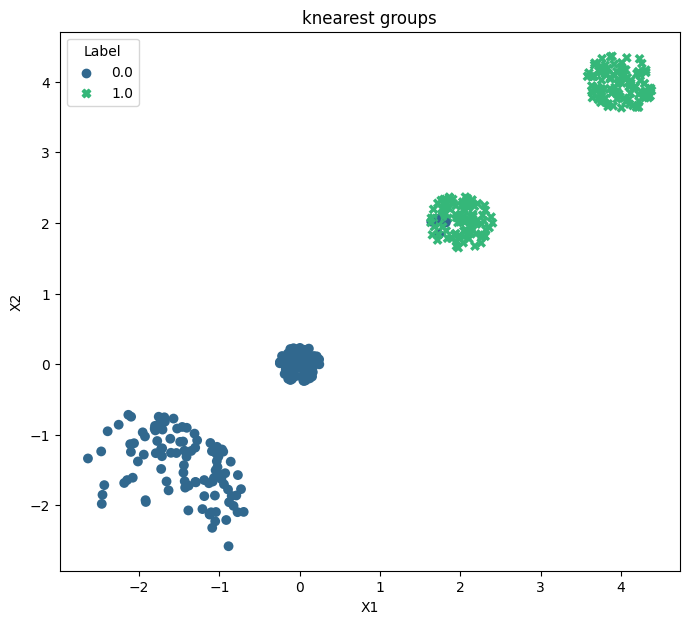

In [153]:

def get_neighbors(df, k, n_points, criteria='Random', given_centers = None):

    final = []

    if criteria == 'Random':
        random.seed(2349324)
        np.random.seed(2349324)
        center_indices  = df.sample(n=n_points).index
        points = df[['X1', 'X2']]


        points_dict = {idx: (points.loc[idx, 'X1'], points.loc[idx, 'X2']) for idx in  center_indices}
        kdtree = KDTree(points)

        for point in points_dict.keys():
            distances, indices = kdtree.query(points_dict[point], k=k)
            final.append((point, list(df.iloc[indices].index)))


    elif criteria == "Given":
        center_indices = given_centers
        points = df[['X1', 'X2']]
        kdtree = KDTree(points)

        for point in center_indices:
            distances,indices = kdtree.query(point, k=k)
            final.append((point, list(df.iloc[indices].index)))

    return final






def get_points_idx(indices,df):

    references = [x[0] for x in indices]
    points = [x[1] for x in indices]

    all = references+list(flatten(points))

    return df.loc[all].copy()


def get_points_coord(coord,df):

    center = [x[0] for x in coord]
    points = [x[1] for x in coord]

    all = flatten(points)

    return df.loc[all].copy()



ktest = get_points_coord(get_neighbors(interleaved, 100, 1,criteria='Given', given_centers = [(-2,-2),(2,2),(0,0),(4,4)]),interleaved)


plt.figure(figsize=(8,7))
sns.scatterplot(data=ktest, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=50, linewidth=0)
plt.title("knearest groups")


ktest

In [154]:

testdata = create_data(5000)


train = testdata.sample(frac=0.8, random_state=1)
test = testdata.drop(train.index)


slope, intercept = train_predict(Data(x_train = train[['X1','X2']], y_train= train['Label'], x_test = test[['X1','X2']], y_test = test['Label']), output="equation")

# CONJOINT_5 = area_group_matrix(train,test,[x[1] for x in get_neighbors(train, 5,1000)])
# CONJOINT_500 = area_group_matrix(train,test,[x[1] for x in get_neighbors(train, 500,1000)])






In [155]:
def run_MPI(matrix):
    new_df = matrix.mask(matrix < 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]

def run_MSPI(matrix):
    class_df = matrix.mask(matrix < 0, 0).mask(matrix > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df[['Influence']]

def run_MSNI(matrix):
    class_df = matrix.mask(matrix > 0, 0).mask(matrix < 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return  class_df[['Influence']]

def run_MNI(matrix):
    new_df = matrix.mask(matrix > 0, 0)
    new_df['Influence'] = new_df.sum(axis=1)*-1
    return new_df[['Influence']]

def run_MAI(matrix):
    new_df = matrix.abs()
    new_df['Influence'] = new_df.sum(axis=1)
    return new_df[['Influence']]

def retrieve(original, result):
    return original.join(result).dropna()

def run_PIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MPI(new_df)

def run_NIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MNI(new_df)

def run_AIL(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    return run_MAI(new_df)

def run_SLIP(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    class_df = new_df.mask(new_df < 0, 0).mask(new_df > 0, 1)
    class_df['Influence'] = class_df.sum(axis=1)
    return class_df[['Influence']]

def run_SLIN(df, matrix, class_label):
    transposed = matrix.T.join(df).drop(['X1','X2'],axis=1)
    new_df = transposed[transposed['Label'] == class_label].drop('Label', axis=1).T
    class_df = new_df.mask(new_df < 0, 1).mask(new_df > 0, 0)
    class_df['Influence'] = class_df.sum(axis=1)
    return class_df[['Influence']]









In [156]:



def get_inf_graph(matrix):

    indexes = list(set(flatten([eval(x) for x in matrix.index])))
    df = pd.DataFrame(index=indexes, columns=['Influence'])
    for indexes in matrix.index:
         for idx in eval(indexes):
             df.loc[idx]=(matrix.loc[indexes]['Influence'])
    return df





# #plot_signal(MPI, "PIL1")
# lo = list(range(len(CONJOINT_50)))
# sd = []
# group_dict = dict(zip(lo,CONJOINT_50.index))
# result = {}
# for k,v in group_dict.items():
#     for idx in eval(v):
#         result[idx] = k


# df = pd.DataFrame.from_dict(result, orient='index', columns=['Group'])
# group_labeling = df.join(testdata).copy()

# group_labeling

In [157]:

def split(df, size = 0.2):
    x = df[['X1','X2']]
    y = df['Label']

    if size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size, random_state=2349324)
        return Data(x_train = x_train,x_test=x_test,y_train = y_train,y_test=y_test)

    else:
        return Data(x_train=x, y_train=y, x_test = x_test, y_test = y_test)




def leave_one_out(df, inf_type="individual", n=1):

    loo_dfs = []
    if inf_type=='individual':
        for i in df.index:
            loo_dfs.append((i,df.drop([i])))

    if inf_type=='group':
        for i in df.index:
            datapoints_to_remove = (random.sample(list(df.index), n))
            loo_dfs.append((datapoints_to_remove,df.drop(datapoints_to_remove)))

    return loo_dfs

def influence_matrix(train,test):
    influences = []
    shr_x_train = train[['X1','X2']]
    shr_y_train = train['Label']
    shr_x_test  = test[['X1','X2']]
    shr_y_test  = test['Label']


    full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
    datasets = leave_one_out(shr_x_train)
    inf_matrix = pd.DataFrame(0, index=list(shr_x_train.index), columns=list(shr_x_test.index))

    for ds in tqdm(datasets):
        data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
        y_pred,y_proba = pred_and_prob(data)
        influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
        inf_matrix.loc[ds[0]] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

    return inf_matrix


In [158]:
#INDIVIDUAL_INFLUENCE = influence_matrix(train,test)

In [159]:
def aggregate_ind(ind_matrix, group_matrix):
    sum_array = []
    aggregate_matrix = pd.DataFrame(0, index=group_matrix.index, columns=group_matrix.columns)
    for index in tqdm(group_matrix.index):
        sum = 0
        for indv in eval(index):
            sum+=np.array(ind_matrix.loc[indv])
        aggregate_matrix.loc[index] = sum
    return aggregate_matrix




# AGGREGATED_5 = aggregate_ind(INDIVIDUAL_INFLUENCE, CONJOINT_5)
# AGGREGATED_50 = aggregate_ind(INDIVIDUAL_INFLUENCE, CONJOINT_50)
# AGGREGATED_500 = aggregate_ind(INDIVIDUAL_INFLUENCE, CONJOINT_500)


In [160]:
# plt.figure(figsize=(20, 5))


# xmin = -0
# xmax = 2

# k500 = CONJOINT_500/AGGREGATED_500
# k500['ratio'] = k500.mean(axis=1)
# ecdfk500 = ECDF(k500['ratio'])
# dfk500 = pd.DataFrame({'x': ecdfk500.x, 'y': ecdfk500.y})
# sns.ecdfplot(data=dfk500, x='x', label='n = 500')
# plt.xlim(xmin, xmax)


# k50 = CONJOINT_50/AGGREGATED_50
# k50['ratio'] = k50.mean(axis=1)
# ecdfk50 = ECDF(k50['ratio'])
# dfk50 = pd.DataFrame({'x': ecdfk50.x, 'y': ecdfk50.y})
# sns.ecdfplot(data=dfk50, x='x', label='n = 50')
# plt.xlim(xmin, xmax)


# k5 = CONJOINT_5/AGGREGATED_5
# k5['ratio'] = k5.mean(axis=1)
# ecdfk5 = ECDF(k5['ratio'])
# dfk5 = pd.DataFrame({'x': ecdfk5.x, 'y': ecdfk5.y})
# sns.ecdfplot(data=dfk5, x='x', label='n = 5')
# plt.xlim(xmin, xmax)


# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Conjoint / Aggregation Influence Ratio ECDF')
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(FixedFormatter([x for x in plt.gca().get_xticks()]))


# plt.axvline(x=1, color='black', linestyle='--')
# plt.legend()  # Add a legend to show the labels
# plt.show()

In [161]:

# def group_influence_matrix(train,test, n):
#     influences = []
#     shr_x_train = train[['X1','X2']]
#     shr_y_train = train['Label']
#     shr_x_test  = test[['X1','X2']]
#     shr_y_test  = test['Label']

#     full_loss = train_predict(Data(x_train = shr_x_train, y_train= shr_y_train, x_test = shr_x_test, y_test = shr_y_test))
#     datasets = leave_one_out(shr_x_train, inf_type='group', n=n)
#     groups = [str(loo[0]) for loo in datasets]

#     str_id_data = [((str(loo[0])),loo[1]) for loo in datasets]

#     inf_matrix = pd.DataFrame(0, index=groups, columns=list(shr_x_test.index))


#     for ds in tqdm(datasets):
#         data = Data(x_train = ds[1], y_train= shr_y_train.drop(ds[0]), x_test = shr_x_test, y_test = shr_y_test)
#         y_pred,y_proba = pred_and_prob(data)
#         influences.append((binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss)))
#         inf_matrix.loc[str(ds[0])] = (binary_cross_entropy(list(data.y_test), y_proba)-np.array(full_loss))

#     if inf_matrix.index.duplicated().any():
#         inf_matrix = inf_matrix[~inf_matrix.index.duplicated(keep='first')]


#     return inf_matrix


# RANDOM_CONJOINT_5 = group_influence_matrix(train,test, 5).head(1000)
# RANDOM_CONJOINT_50 = group_influence_matrix(train,test, 50).head(1000)
# RANDOM_CONJOINT_500 = group_influence_matrix(train,test, 500).head(1000)

In [162]:



# def ecdf(influence_matrix_1, influence_matrix_2):
#     assert influence_matrix_1.shape == influence_matrix_2.shape

#     # The function assumes that rows represent the train sample ids and
#     # columns the test sample ids. The correlations are computed column-wise.
#     # This is because this structure implies the many-to-one relation, i.e., many train examples (or groups)
#     # to one test example

#     corr_vals = {}
#     #p_value_threshold = 0.05

#     for col in influence_matrix_1.columns:
#         spearman_r, pval = spearmanr(
#             influence_matrix_1.loc[:, col], influence_matrix_2.loc[:, col]
#         )
#         #if pval <= p_value_threshold:
#         corr_vals[col] = spearman_r
#     print(
#         "Statistically significant in rows count:",
#         len(corr_vals) / influence_matrix_1.shape[1],
#     )
#     return ECDF(list(corr_vals.values()))


# # def plot_ecdf(ecdf_arr):
# #     data, ecdf =
# #     pass

# def plot_ecdf(ecdf_obj,title):
#     # Convert ECDF object to Pandas DataFrame
#     df = pd.DataFrame({'x': ecdf_obj.x, 'y': ecdf_obj.y})

#     # Plot ECDF using Seaborn
#     sns.ecdfplot(data=df, x='x')
#     plt.xlabel('X')
#     plt.ylabel('ECDF')
#     plt.title(title)
#     plt.grid(True)
#     plt.show()







In [163]:
# plt.figure(figsize=(15, 5))

# ##KNN GROUPING

# ecdfKNN5 = ecdf(CONJOINT_5, AGGREGATED_5)
# df_KNN5 = pd.DataFrame({'x': ecdfKNN5.x, 'y': ecdfKNN5.y})
# sns.ecdfplot(data=df_KNN5, x='x', label='Nearest Neighbour Grouping, n=5',color='blue')

# # ecdfKNN50 = ecdf(CONJOINT_50, AGGREGATED_50)
# # df_KNN50 = pd.DataFrame({'x': ecdfKNN50.x, 'y': ecdfKNN50.y})
# # sns.ecdfplot(data=df_KNN50, x='x', label='Nearest Neighbour Grouping, n=50',color='red')

# ecdfKNN500 = ecdf(CONJOINT_500, AGGREGATED_500)
# df_KNN500 = pd.DataFrame({'x': ecdfKNN500.x, 'y': ecdfKNN500.y})
# sns.ecdfplot(data=df_KNN500, x='x', label='Nearest Neighbour Grouping, n=500',color='red')


# ## RANDOM GROUPING

# ecdfR5 = ecdf(RANDOM_CONJOINT_5, aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_5))
# df_r5 = pd.DataFrame({'x': ecdfR5.x, 'y': ecdfR5.y})
# sns.ecdfplot(data=df_r5, x='x', label='Random Grouping,n = 5',linestyle="--",color='blue')

# # ecdfR50 = ecdf(RANDOM_CONJOINT_50, aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_50))
# # df_r50 = pd.DataFrame({'x': ecdfR50.x, 'y': ecdfR50.y})
# # sns.ecdfplot(data=df_r50, x='x', label='Random Grouping,n = 50',linestyle="--",color='red')

# ecdfR500 = ecdf(RANDOM_CONJOINT_500, aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_500))
# df_r500 = pd.DataFrame({'x': ecdfR500.x, 'y': ecdfR500.y})
# sns.ecdfplot(data=df_r500, x='x', label='Random Grouping,n = 500',linestyle="--",color='red')


# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Random vs KNN Grouping ECDFs')
# plt.grid(True)

# plt.gca().xaxis.set_major_formatter(FixedFormatter(['{:0.5f}'.format(x) for x in plt.gca().get_xticks()]))



# plt.legend()  # Add a legend to show the labels
# plt.show()


In [164]:
# plt.figure(figsize=(15, 5))


# xmin = 0.5
# xmax = 1.5

# k5 = CONJOINT_5/AGGREGATED_5
# k5['ratio'] = k5.mean(axis=1)
# ecdfk5 = ECDF(k5['ratio'])
# dfk5 = pd.DataFrame({'x': ecdfk5.x, 'y': ecdfk5.y})
# sns.ecdfplot(data=dfk5, x='x', label='KNN, n = 5',color='blue')
# plt.xlim(xmin, xmax)

# k500 = CONJOINT_500/AGGREGATED_500
# k500['ratio'] = k500.mean(axis=1)
# ecdfk500 = ECDF(k500['ratio'])
# dfk500 = pd.DataFrame({'x': ecdfk500.x, 'y': ecdfk500.y})
# sns.ecdfplot(data=dfk500, x='x', label='KNN, n = 500',color='red')
# plt.xlim(xmin, xmax)

# r5 = RANDOM_CONJOINT_5/aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_5)
# r5['ratio'] = r5.mean(axis=1)
# ecdfr5 = ECDF(r5['ratio'])
# dfr5 = pd.DataFrame({'x': ecdfr5.x, 'y': ecdfr5.y})
# sns.ecdfplot(data=dfr5, x='x', label='Random, n = 5',linestyle="--",color='blue')
# plt.xlim(xmin, xmax)


# r500 = RANDOM_CONJOINT_500/aggregate_ind(INDIVIDUAL_INFLUENCE, RANDOM_CONJOINT_500)
# r500['ratio'] = r500.mean(axis=1)
# ecdfr500 = ECDF(r500['ratio'])
# dfr500 = pd.DataFrame({'x': ecdfr500.x, 'y': ecdfr500.y})
# sns.ecdfplot(data=dfr500, x='x', label='Random, n = 500',linestyle="--",color='red')
# plt.xlim(xmin, xmax)


# plt.xlabel('X')
# plt.ylabel('ECDF')
# plt.title('Conjoint / Aggregation Influence Ratio ECDF')
# plt.grid(True)

# #plt.gca().xaxis.set_major_formatter(FixedFormatter([x for x in plt.gca().get_xticks()]))


# plt.axvline(x=1, color='black', linestyle='--')
# plt.legend()  # Add a legend to show the labels
# plt.show()

In [165]:
CONJOINT_50 = area_group_matrix(train,test,[x[1] for x in get_neighbors(train, 50,50)])

CONJOINT_50

100%|██████████| 50/50 [00:03<00:00, 15.59it/s]


2     \
[3133, 4175, 4558, 2653, 4316, 3336, 3052, 3357...  3.622793e-08   
[2704, 3347, 3241, 4835, 3154, 4762, 2826, 4165...  2.337123e-07   
[528, 622, 429, 1352, 1715, 857, 724, 325, 308,...  3.215190e-08   
[1744, 93, 276, 36, 1051, 305, 1532, 1384, 189,...  1.445968e-08   
[1850, 1201, 1661, 2197, 2107, 1338, 1950, 343,... -6.866241e-10   
[3670, 3298, 3273, 2536, 4619, 4922, 4189, 3969...  1.099394e-07   
[2965, 4435, 2878, 4024, 2677, 3539, 2740, 4363...  6.865329e-07   
[3703, 3506, 3401, 4876, 2661, 3950, 4605, 4366...  1.799210e-07   
[392, 2123, 346, 2227, 2330, 1768, 785, 515, 18...  1.491836e-08   
[3963, 2601, 3953, 3261, 3004, 3282, 4018, 3972...  3.629909e-07   
[2051, 2114, 554, 1394, 2142, 320, 484, 1215, 2... -7.989987e-08   
[2287, 874, 331, 434, 221, 1740, 1336, 2314, 40... -7.905575e-07   
[4657, 4192, 4578, 3733, 3944, 3858, 3411, 4921...  7.816904e-10   
[4511, 3285, 3604, 3923, 4583, 3794, 3680, 3748...  1.747205e-07   
[3322, 2969, 4970, 4380, 4852, 3440, 2711, 3040...  4.928416e-07   
[4257, 4471, 3673, 2692, 2917, 2626, 4551, 3910...  2.721505e-08   
[4363, 2740, 2677, 2748, 4693, 2965, 4435, 2554...  5.158690e-07   
[3008, 3875, 2656, 3781, 4046, 4879, 3741, 4683...  8.174250e-08   
[661, 217, 1435, 215, 474, 1113, 1082, 2027, 47...  2.575721e-08   
[3745, 4917, 2718, 3473, 2681, 3501, 3680, 3794...  1.295651e-07   
[3833, 2742, 3430, 3929, 4999, 4401, 4067, 4661... -5.786947e-09   
[3218, 2529, 3516, 4616, 2663, 4193, 3379, 2935...  8.118123e-07   
[1569, 632, 1087, 1129, 2337, 2420, 789, 2481, ...  1.051127e-08   
[1044, 2238, 1208, 2179, 523, 2320, 2347, 384, ...  1.663947e-07   
[4648, 2796, 2970, 4906, 3714, 3306, 3643, 4585...  1.286025e-08   
[556, 1707, 693, 2271, 2054, 911, 709, 1104, 21... -1.061361e-08   
[2610, 3141, 4542, 2678, 2793, 3698, 4292, 3203...  7.903721e-07   
[2793, 2678, 4349, 2610, 3698, 3090, 3141, 4542...  1.165496e-06   
[2089, 560, 906, 362, 1397, 524, 540, 1818, 245...  1.549263e-07   
[4954, 4719, 4046, 3504, 3781, 4879, 2731, 3008...  8.547485e-08   
[1005, 1596, 190, 1575, 2249, 1728, 1509, 56, 1... -1.293685e-08   
[3655, 4997, 3535, 3931, 3867, 4203, 2702, 4973... -4.302797e-09   
[3041, 4664, 2927, 4975, 3752, 3168, 3186, 2741... -8.643179e-09   
[4176, 2974, 4258, 3743, 3249, 4088, 2595, 3802...  9.055086e-08   
[4768, 3213, 3499, 4629, 3957, 3674, 4317, 3644...  1.913589e-08   
[4605, 3271, 3401, 3773, 3488, 3703, 3506, 4478...  2.347285e-07   
[906, 2089, 560, 524, 362, 540, 1397, 1818, 245...  1.510449e-07   
[4792, 3933, 4135, 3762, 4075, 2520, 4771, 4839... -1.014077e-10   
[4709, 3407, 4246, 3214, 3573, 2907, 2809, 3801...  8.682245e-07   
[34, 1535, 1277, 1792, 188, 406, 627, 1438, 460...  3.789155e-09   
[4505, 3504, 2733, 4879, 4046, 3024, 3741, 4954...  5.535558e-08   
[1696, 1448, 1917, 1244, 1558, 1166, 790, 1757,...  1.673036e-07   
[2817, 3274, 3587, 4989, 3469, 3813, 2823, 3940...  2.231532e-08   
[3256, 2909, 2634, 3305, 3603, 3769, 3537, 4405...  1.381679e-09   
[1190, 1780, 426, 1489, 1219, 1203, 2207, 1866,...  5.232222e-07   
[2006, 115, 2487, 533, 1853, 1863, 1391, 122, 2...  2.236405e-07   
[2982, 3634, 4824, 4087, 3949, 4194, 2765, 4969...  9.533802e-09   
[2723, 3686, 3289, 3315, 4128, 2558, 3705, 4688... -6.235600e-09   
[4795, 3064, 3856, 2971, 4526, 3237, 2500, 3327... -3.322356e-07   
[3401, 3703, 4876, 3506, 2661, 3950, 4323, 4605...  1.825228e-07   

                                                            9     \
[3133, 4175, 4558, 2653, 4316, 3336, 3052, 3357...  7.641952e-09   
[2704, 3347, 3241, 4835, 3154, 4762, 2826, 4165...  6.462495e-08   
[528, 622, 429, 1352, 1715, 857, 724, 325, 308,...  7.637763e-09   
[1744, 93, 276, 36, 1051, 305, 1532, 1384, 189,...  3.595946e-09   
[1850, 1201, 1661, 2197, 2107, 1338, 1950, 343,... -7.454735e-11   
[3670, 3298, 3273, 2536, 4619, 4922, 4189, 3969...  2.485489e-08   
[2965, 4435, 2878, 4024, 2677, 3539, 2740, 4363...  1.820834e-07   
[3703, 3506, 3401, 4876, 2661, 3950, 4605, 4366

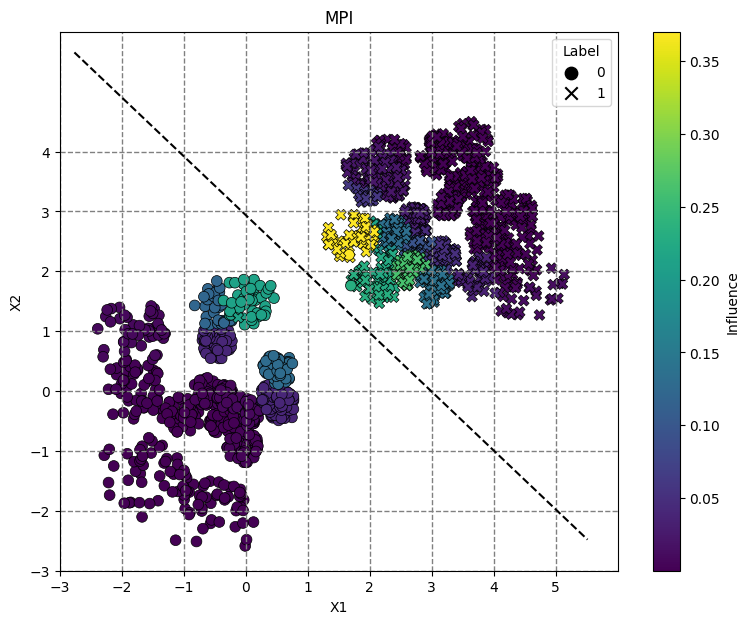

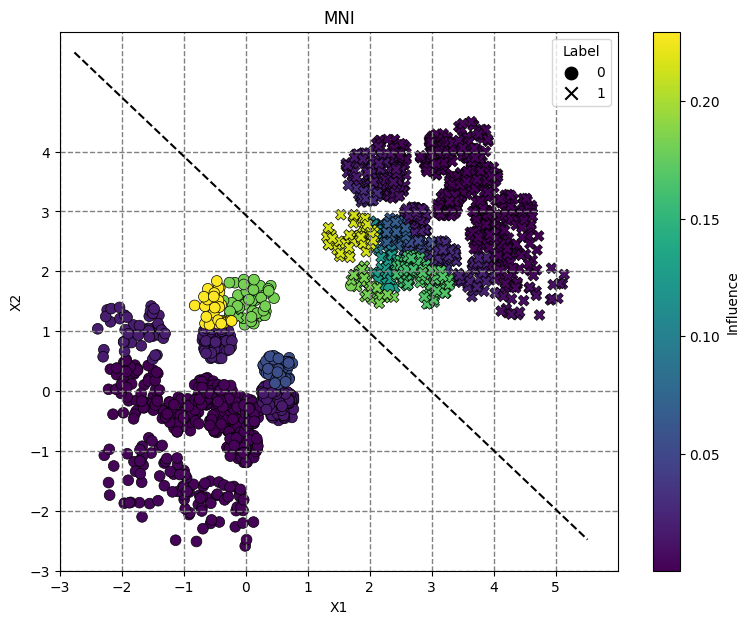

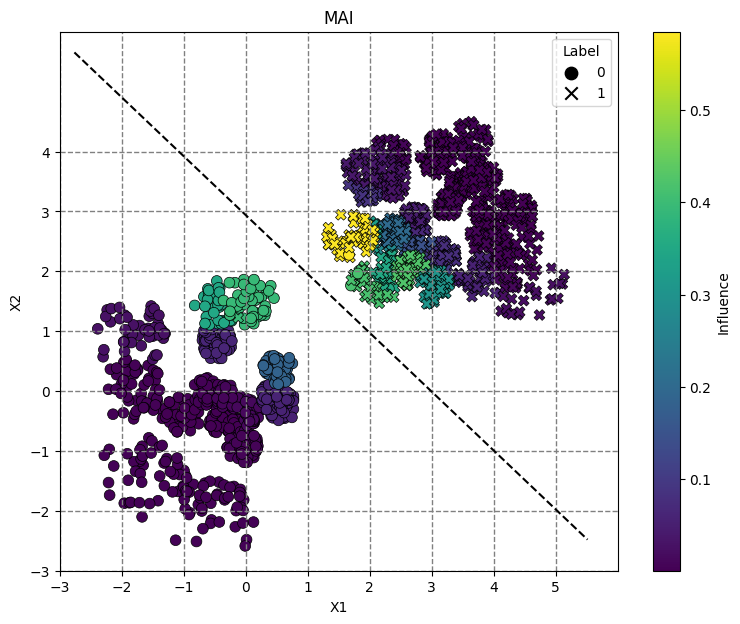

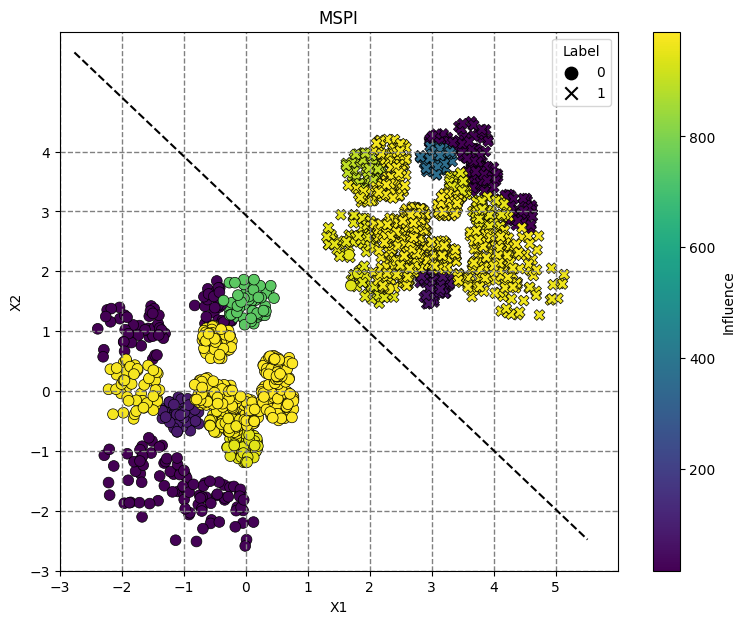

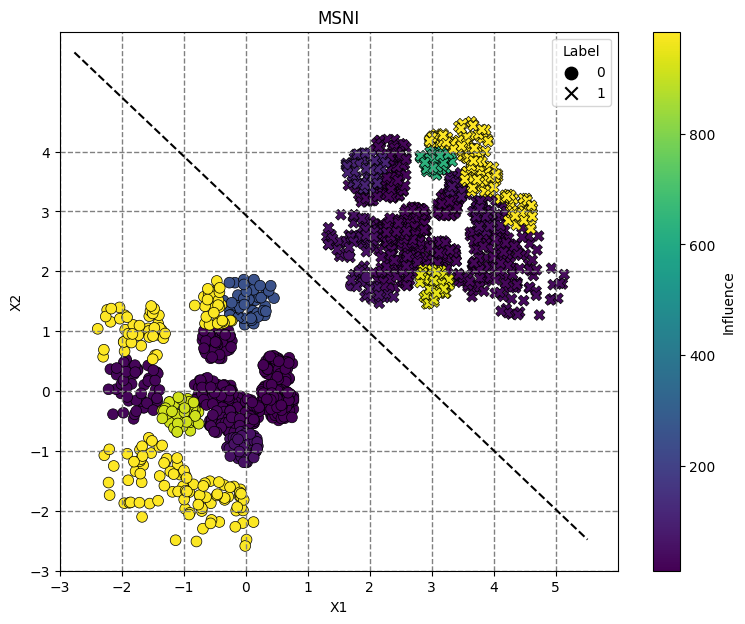

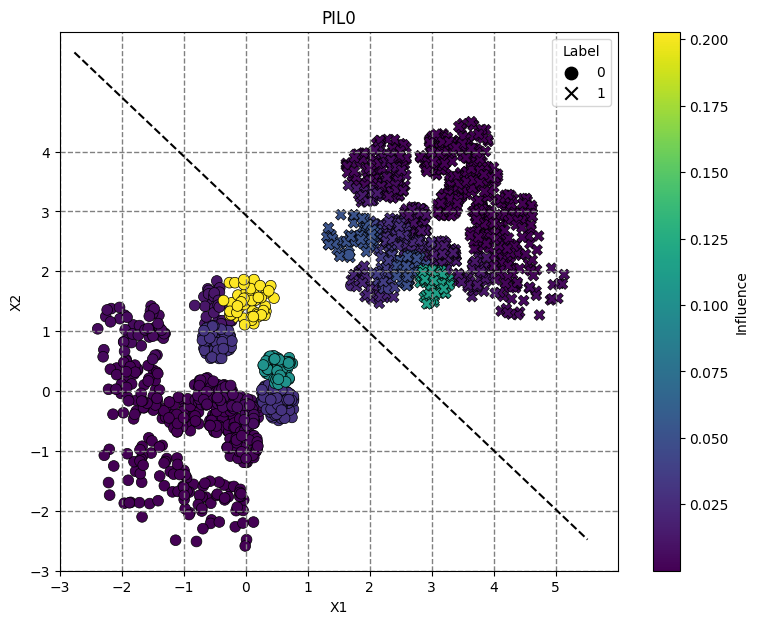

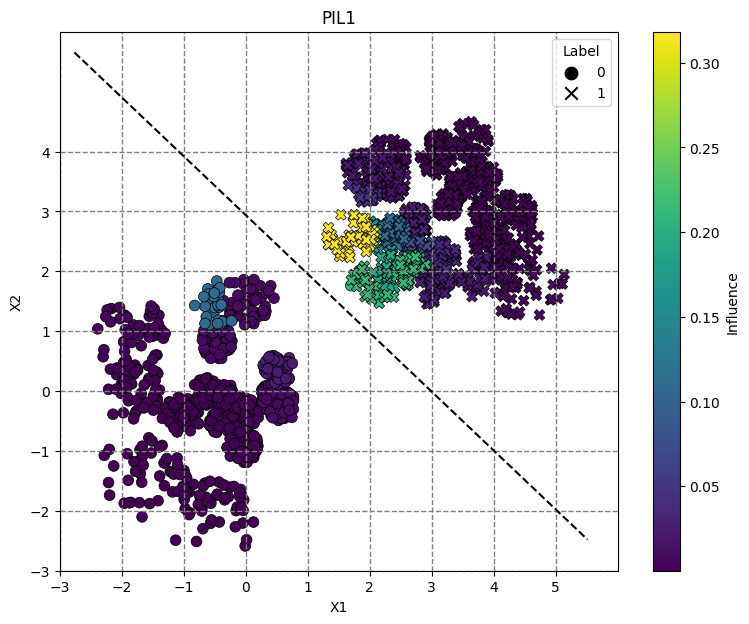

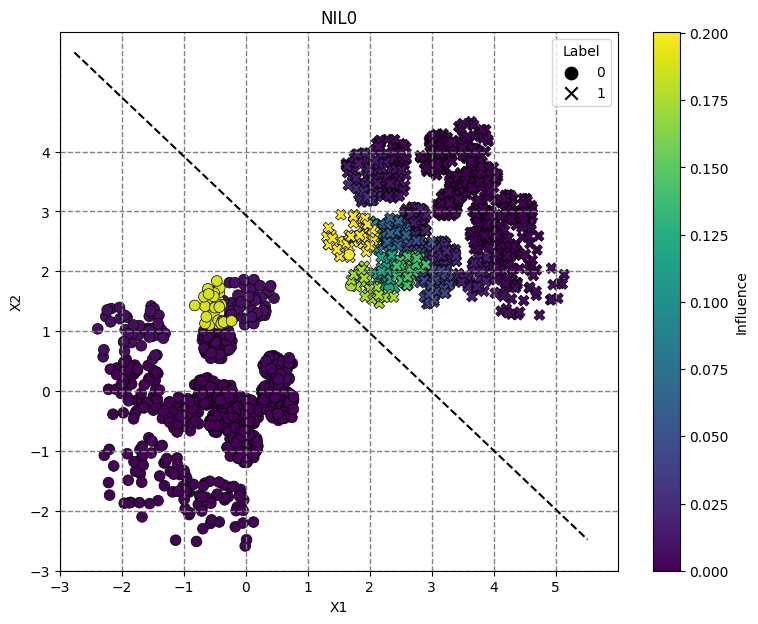

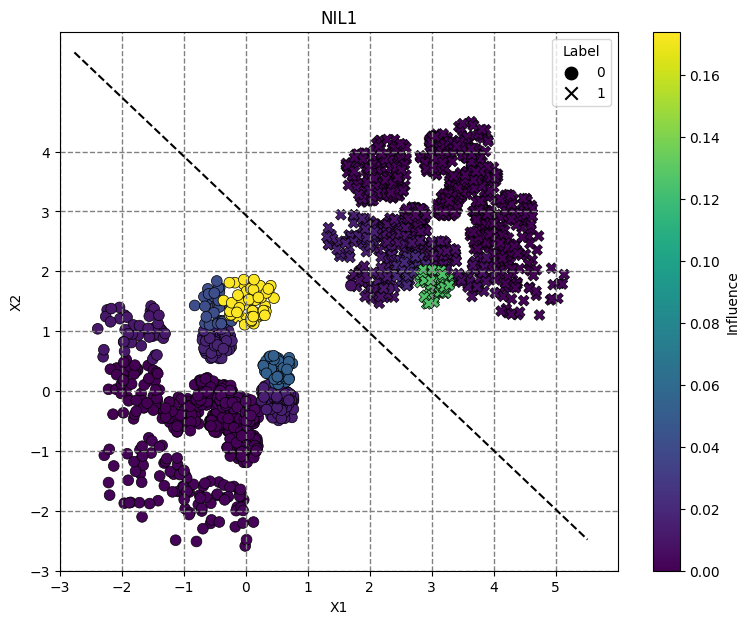

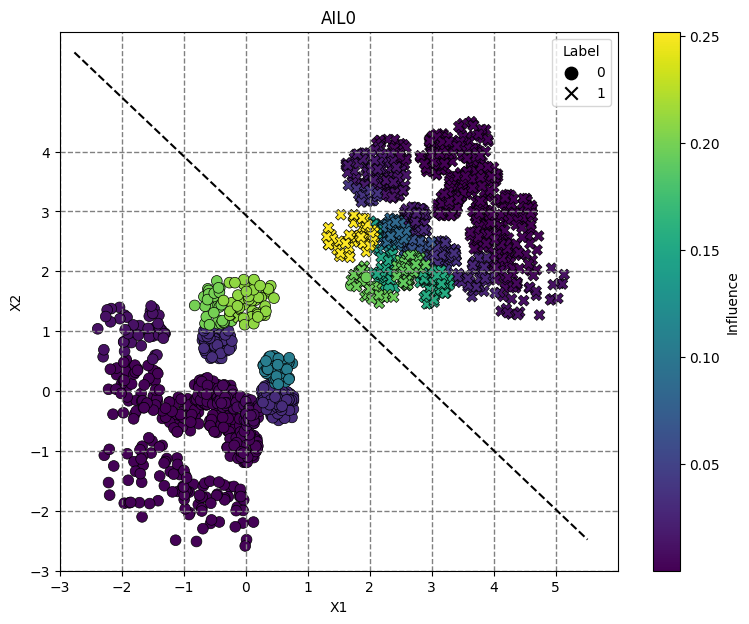

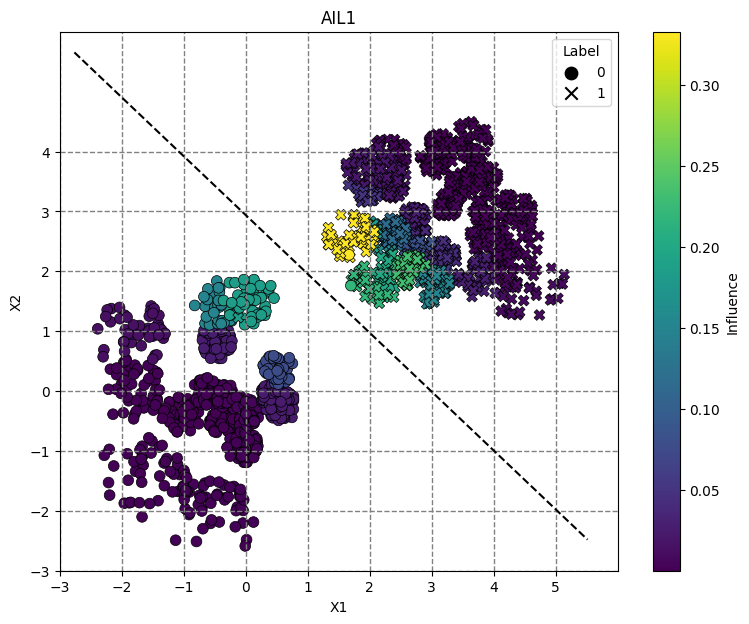

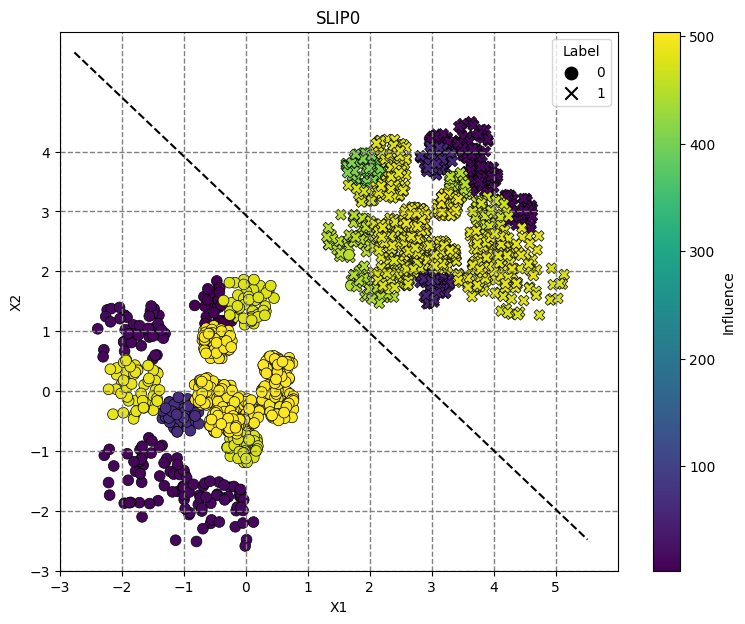

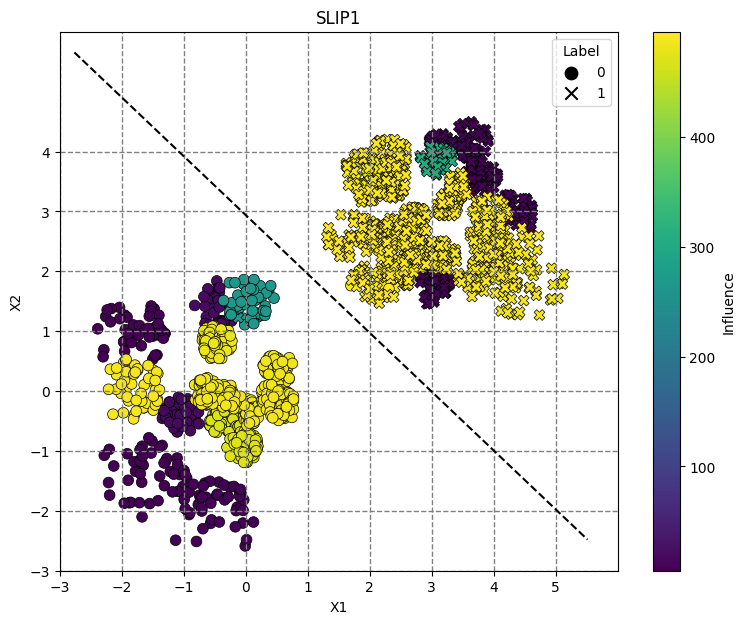

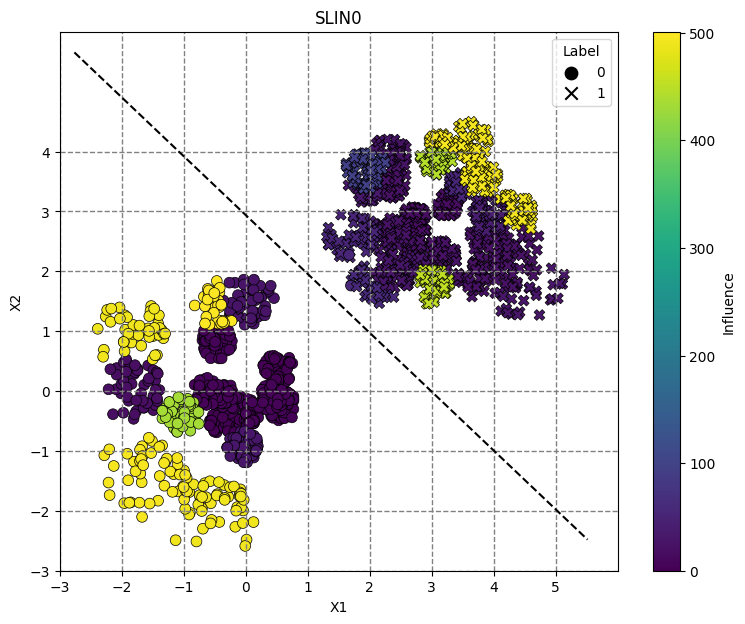

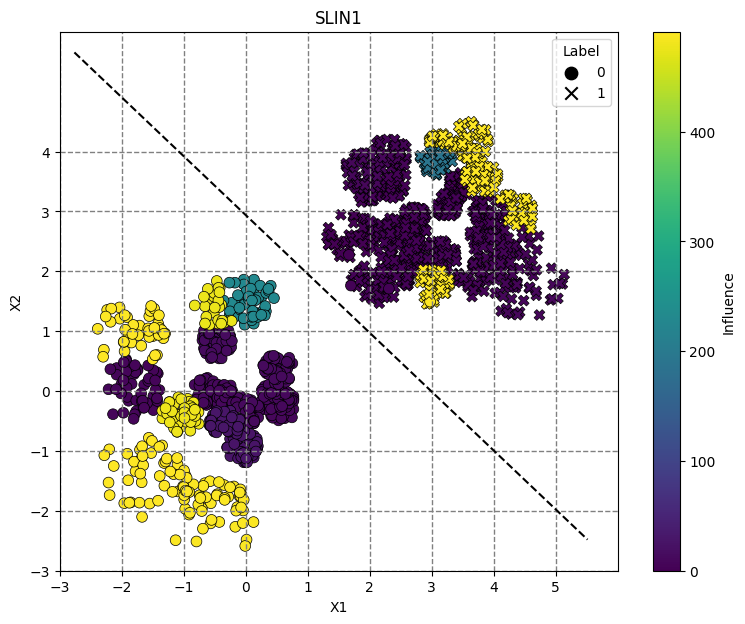

In [166]:

def plot_signal(df, title,xlim = (-3,6), ylim = (-3,6),save=False):
    plt.figure(figsize=(9, 7))
    kwargs = {'edgecolor': "black", 'linewidth': 0.5}
    sp = sns.scatterplot(data=df.sort_values('Influence'), x='X1', y='X2', hue='Influence', legend='brief', style='Label', palette='viridis', s=60, **kwargs,alpha=1)
    #sp.get_legend().remove()

    custom_handles = [
        plt.scatter([], [], marker='o', s=80, color='black', label='0'),
        plt.scatter([], [], marker='x', s=80, color='black', label='1'),
    ]

    plt.legend(handles=custom_handles, title='Label')

    norm = plt.Normalize(df['Influence'].min(), df['Influence'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sp.figure.colorbar(sm, ax=sp).set_label('Influence')
    sp.set(title=title)

    x_limits = plt.gca().get_xlim()
    y_limits = plt.gca().get_ylim()

    # Determine the range of x values based on the plot limits
    x = np.linspace(min(x_limits), max(x_limits), 100)

    # Compute the corresponding y values for y = -x
    y = x*slope+intercept

    plt.plot(x, y, 'k--')

    x_ticks = np.arange(np.floor(min(x_limits)), np.ceil(max(x_limits)), 1)
    y_ticks = np.arange(np.floor(min(y_limits)), np.ceil(max(y_limits)), 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.grid(True, linewidth=1, linestyle='--', color='gray')


    plt.xlim(xlim)
    plt.ylim(ylim)


    if save:
        plt.savefig(title+'.png')
    else:
        plt.show()




def get_inf_graph(matrix):

    indexes = list(set(flatten([eval(x) for x in matrix.index])))
    df = pd.DataFrame(index=indexes, columns=['Influence'])
    for indexes in matrix.index:
        for idx in eval(indexes):
            df.loc[idx]=matrix.loc[indexes]['Influence']
    return df




#PIL0
#PIL1
#NIL0
#NIL1
#AIL0
#AIL1

#SLIP0
#SLIP1
#SLIN0
#SLIP1


plot_signal(get_inf_graph(run_MPI(CONJOINT_50)).join(testdata),  "MPI")
plot_signal(get_inf_graph(run_MNI(CONJOINT_50)).join(testdata),  "MNI")
plot_signal(get_inf_graph(run_MAI(CONJOINT_50)).join(testdata),  "MAI")
plot_signal(get_inf_graph(run_MSPI(CONJOINT_50)).join(testdata), "MSPI")
plot_signal(get_inf_graph(run_MSNI(CONJOINT_50)).join(testdata), "MSNI")


plot_signal(get_inf_graph(run_PIL(testdata,CONJOINT_50,0)).join(testdata), "PIL0")
plot_signal(get_inf_graph(run_PIL(testdata,CONJOINT_50,1)).join(testdata), "PIL1")

plot_signal(get_inf_graph(run_NIL(testdata,CONJOINT_50,0)).join(testdata), "NIL0")
plot_signal(get_inf_graph(run_NIL(testdata,CONJOINT_50,1)).join(testdata), "NIL1")

plot_signal(get_inf_graph(run_AIL(testdata,CONJOINT_50,0)).join(testdata), "AIL0")
plot_signal(get_inf_graph(run_AIL(testdata,CONJOINT_50,1)).join(testdata), "AIL1")

plot_signal(get_inf_graph(run_SLIP(testdata,CONJOINT_50,0)).join(testdata), "SLIP0")
plot_signal(get_inf_graph(run_SLIP(testdata,CONJOINT_50,1)).join(testdata), "SLIP1")

plot_signal(get_inf_graph(run_SLIN(testdata,CONJOINT_50,0)).join(testdata), "SLIN0")
plot_signal(get_inf_graph(run_SLIN(testdata,CONJOINT_50,1)).join(testdata), "SLIN1")





In [167]:
## MARGINAL SIGNALS

#SEGREGATED = INDIVIDUAL_INFLUENCE.loc[list(set(flatten([eval(x) for x in CONJOINT_50.index])))]





# plot_signal(run_MPI(SEGREGATED).join(testdata),"MPI")
# plot_signal(run_MNI(SEGREGATED).join(testdata),"MNI")
# plot_signal(run_MAI(SEGREGATED).join(testdata),"MAI")
# plot_signal(run_MSPI(SEGREGATED).join(testdata),"MSPI")
# plot_signal(run_MSNI(SEGREGATED).join(testdata),"MSNI")


# plot_signal(run_PIL(testdata,SEGREGATED,0).join(testdata),"PIL0")
# plot_signal(run_PIL(testdata,SEGREGATED,1).join(testdata),"PIL1")

# plot_signal(run_NIL(testdata,SEGREGATED,0).join(testdata),"NIL0")
# plot_signal(run_NIL(testdata,SEGREGATED,1).join(testdata),"NIL1")


# plot_signal(run_AIL(testdata,SEGREGATED,0).join(testdata),"AIL0")
# plot_signal(run_AIL(testdata,SEGREGATED,1).join(testdata),"AIL1")

# plot_signal(run_SLIP(testdata,SEGREGATED,0).join(testdata),"SLIP0")
# plot_signal(run_SLIP(testdata,SEGREGATED,1).join(testdata),"SLIP1")

# plot_signal(run_SLIN(testdata,SEGREGATED,0).join(testdata),"SLIN0")
# plot_signal(run_SLIN(testdata,SEGREGATED,1).join(testdata),"SLIN1")






(-3.4, 5.4)

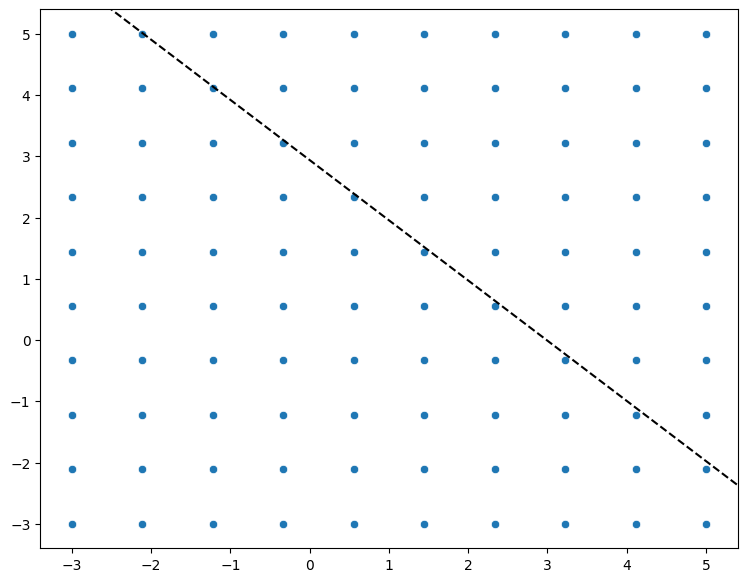

In [168]:
centers_x = np.linspace(-3,5,10)
centers_y = np.linspace(-3,5,10)

points = list(itertools.product(centers_x, centers_y))

plt.figure(figsize=(9, 7))

sns.scatterplot(x = [t[0] for t in points], y= [t[1] for t in points])
x_limits = plt.gca().get_xlim()
y_limits = plt.gca().get_ylim()

# Determine the range of x values based on the plot limits
x = np.linspace(min(x_limits), max(x_limits), 100)

# Compute the corresponding y values for y = -x
y = x*slope+intercept

plt.plot(x, y, 'k--')

plt.xlim(x_limits)
plt.ylim(y_limits)

In [169]:
#ktest = get_points_coord(get_neighbors(train, 5, 1,criteria='Given', given_centers = points),train)


def get_points_coord(coord,df):

    center = [x[0] for x in coord]
    points = [x[1] for x in coord]


    all = flatten(points)

    points_df = df.loc[all].copy()


    colors_list = [0,1]
    nueva_lista = [(tupla[0],tupla[1], color) for tupla, color in zip(coord, itertools.cycle(colors_list))]

    values = []
    colors = []
    for item in nueva_lista:
        value_group = item[1]
        color = item[2]
        values.extend(value_group)
        colors.extend([color] * len(value_group))

    # Crear el DataFrame
    color_df = pd.DataFrame({'Color': colors}, index=values)
    points_df['Color'] = color_df['Color']
    return points_df



get_points_coord(get_neighbors(train, 5, 1,criteria='Given', given_centers = points),train)




X1        X2  Label  Color
464  -2.196111 -1.737977    0.0      0
2296 -1.960127 -1.873104    0.0      0
1937 -1.445193 -2.794198    0.0      0
1961 -1.878010 -1.865277    0.0      0
1579 -1.672782 -2.101019    0.0      0
...        ...       ...    ...    ...
4878  4.726778  4.685460    1.0      1
2804  5.475695  4.792459    1.0      1
3749  4.722475  4.550955    1.0      1
3951  4.453922  5.150552    1.0      1
3934  5.004118  4.349087    1.0      1

[500 rows x 4 columns]

In [170]:

#ktest = get_points_coord(get_neighbors(train, 5, 1,criteria='Given', given_centers = points),train)


# testdata = create_data(5000)


# train = testdata.sample(frac=0.8, random_state=1)
# test = testdata.drop(train.index)

centers_x = np.linspace(-3,6,9)
centers_y = np.linspace(-3,6,9)
points = list(itertools.product(centers_x, centers_y))
selected = get_points_coord(get_neighbors(train,10, 1,criteria='Given', given_centers = points),train)


def create_scatter_plot(df):
    plt.figure(figsize=(8, 7))
    sp = sns.scatterplot(data=df, x='X1', y='X2', hue='Color', style='Label', s=50, linewidth=0, palette='magma')
    x_limits = plt.gca().get_xlim()
    y_limits = plt.gca().get_ylim()

    # Determine the range of x values based on the plot limits
    x = np.linspace(min(x_limits), max(x_limits), 100)
    # Compute the corresponding y values for y = -x
    y = x * slope + intercept
    plt.plot(x, y, 'k--')


    plt.title("knearest groups")

    x_ticks = np.arange(np.floor(min(x_limits)), np.ceil(max(x_limits)), 1)
    y_ticks = np.arange(np.floor(min(y_limits)), np.ceil(max(y_limits)), 1)
    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.grid(True, linewidth=1, linestyle='--', color='gray')

    sp.get_legend().remove()

    custom_handles = [
        plt.scatter([], [], marker='o', s=80, color='black', label='0'),
        plt.scatter([], [], marker='x', s=80, color='black', label='1'),
    ]

    plt.legend(handles=custom_handles, title='Label')
    plt.xlim((-3,6))
    plt.ylim((-3,6))
    return sp



In [171]:
knn_2 = get_neighbors(train,2, 1,criteria='Given', given_centers = points)
AGM_2 = area_group_matrix(train,test,[x[1] for x in knn_2])

# knn_10 = get_neighbors(train,10, 1,criteria='Given', given_centers = points)
# AGM_10 = area_group_matrix(train,test,[x[1] for x in knn_10])

# knn_100 = get_neighbors(train,100, 1,criteria='Given', given_centers = points)
# AGM_100 = area_group_matrix(train,test,[x[1] for x in knn_100])


# knn_500 = get_neighbors(train,500, 1,criteria='Given', given_centers = points)
# AGM_500 = area_group_matrix(train,test,[x[1] for x in knn_500])


100%|██████████| 81/81 [00:06<00:00, 13.39it/s]


In [172]:



def full_report(matrix,knn, want_file):

    create_scatter_plot(get_points_coord(knn,train))

    plot_signal(get_inf_graph(run_MPI(matrix)).join(testdata), "MPI" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_MNI(matrix)).join(testdata), "MNI" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_MAI(matrix)).join(testdata), "MAI" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_MSPI(matrix)).join(testdata), "MSPI" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_MSNI(matrix)).join(testdata), "MSNI" +", n="+ str(len(knn[0][1])), save= want_file)

    plot_signal(get_inf_graph(run_PIL(testdata,matrix,0)).join(testdata), "PIL-0" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_PIL(testdata,matrix,1)).join(testdata), "PIL-1" +", n="+ str(len(knn[0][1])), save= want_file)

    plot_signal(get_inf_graph(run_NIL(testdata,matrix,0)).join(testdata), "NIL-0" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_NIL(testdata,matrix,1)).join(testdata), "NIL-1" +", n="+ str(len(knn[0][1])), save= want_file)

    plot_signal(get_inf_graph(run_SLIP(testdata,matrix,0)).join(testdata), "SLIP-0" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_SLIP(testdata,matrix,1)).join(testdata), "SLIP-1" +", n="+ str(len(knn[0][1])), save= want_file)

    plot_signal(get_inf_graph(run_SLIN(testdata,matrix,0)).join(testdata), "SLIN-0" +", n="+ str(len(knn[0][1])), save= want_file)
    plot_signal(get_inf_graph(run_SLIN(testdata,matrix,1)).join(testdata), "SLIN-1" +", n="+ str(len(knn[0][1])), save= want_file)

    return None


# full_report(AGM_2, knn_2,True)
# full_report(AGM_10, knn_10,True)
# full_report(AGM_100, knn_100,True)
# full_report(AGM_500, knn_500,False)




In [173]:

# png_files = glob.glob('*.png')

# for file in png_files:
#     files.download(file)



In [174]:
# import os

# # Get the current directory
# current_dir = os.getcwd()

# # Iterate over all files in the directory
# for file_name in os.listdir(current_dir):
#     file_path = os.path.join(current_dir, file_name)

#     # Check if the file is a regular file (not a directory)
#     if os.path.isfile(file_path):
#         os.remove(file_path)


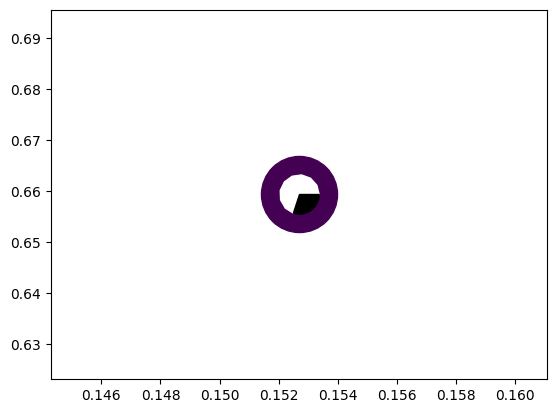

[((-3.0, -3.0), [464, 2296]), ((-3.0, -1.875), [1155, 464]), ((-3.0, -0.75), [2242, 27]), ((-3.0, 0.375), [191, 640]), ((-3.0, 1.5), [1002, 1433]), ((-3.0, 2.625), [1794, 2399]), ((-3.0, 3.75), [293, 1794]), ((-3.0, 4.875), [293, 1794]), ((-3.0, 6.0), [293, 3871]), ((-1.875, -3.0), [1937, 79]), ((-1.875, -1.875), [1961, 1470]), ((-1.875, -0.75), [1677, 1966]), ((-1.875, 0.375), [1570, 1605]), ((-1.875, 1.5), [1999, 166]), ((-1.875, 2.625), [1794, 293]), ((-1.875, 3.75), [293, 1794]), ((-1.875, 4.875), [3871, 293]), ((-1.875, 6.0), [3871, 3525]), ((-0.75, -3.0), [2411, 139]), ((-0.75, -1.875), [1104, 2273]), ((-0.75, -0.75), [763, 275]), ((-0.75, 0.375), [393, 1829]), ((-0.75, 1.5), [1400, 2213]), ((-0.75, 2.625), [1122, 2112]), ((-0.75, 3.75), [3871, 387]), ((-0.75, 4.875), [3871, 3525]), ((-0.75, 6.0), [3525, 4599]), ((0.375, -3.0), [2243, 1276]), ((0.375, -1.875), [1549, 783]), ((0.375, -0.75), [1647, 210]), ((0.375, 0.375), [47, 329]), ((0.375, 1.5), [2361, 882]), ((0.375, 2.625), [

In [175]:
import numpy as np
import matplotlib.pyplot as plt

def drawPieMarker(xs, ys, ratios, sizes, colors):
    assert sum(ratios) <= 1, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 10)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 10)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker)


fig, ax = plt.subplots()

xrand = np.random.rand(1)
yrand = np.random.rand(1)

plt.scatter(xrand,yrand,s=3000,c=1000)





drawPieMarker(xs=xrand,
              ys=yrand,
              ratios=[.7,.3],
              sizes=[800],
              colors=['white','black'])

plt.show()



print(get_neighbors(train,2, 1,criteria='Given', given_centers = points),'\n')
print(run_MPI(AGM_2).join(testdata)['Influence'].head(),'\n')
print(train.head(),'\n')

In [176]:
def center_influence(neighbors, signal):
    xs = []
    ys = []
    indexes = []
    for tup in neighbors:
        xs.append(tup[0][0])
        ys.append(tup[0][1])
        indexes.append(tup[1])

    return neighbors#[xs,ys]


# centers_x = np.linspace(-2,5,5)
# centers_y = np.linspace(-2,5,5)

# points = list(itertools.product(centers_x, centers_y))

ci = center_influence(get_neighbors(train,2, 1,criteria='Given', given_centers = points),run_MPI(AGM_2).join(testdata)['Influence'])


# plt.figure(figsize=(9,9))
# plt.scatter(ci[0],ci[1],s=5000,zorder=3)

# x = np.linspace(-8, 8, 100)
# # Compute the corresponding y values for y = -x
# y = x * slope + intercept
# plt.plot(x, y, 'k--')
# plt.xlim((-3,6))
# plt.ylim((-3,6))

print(ci)

AGM_2

[((-3.0, -3.0), [464, 2296]), ((-3.0, -1.875), [1155, 464]), ((-3.0, -0.75), [2242, 27]), ((-3.0, 0.375), [191, 640]), ((-3.0, 1.5), [1002, 1433]), ((-3.0, 2.625), [1794, 2399]), ((-3.0, 3.75), [293, 1794]), ((-3.0, 4.875), [293, 1794]), ((-3.0, 6.0), [293, 3871]), ((-1.875, -3.0), [1937, 79]), ((-1.875, -1.875), [1961, 1470]), ((-1.875, -0.75), [1677, 1966]), ((-1.875, 0.375), [1570, 1605]), ((-1.875, 1.5), [1999, 166]), ((-1.875, 2.625), [1794, 293]), ((-1.875, 3.75), [293, 1794]), ((-1.875, 4.875), [3871, 293]), ((-1.875, 6.0), [3871, 3525]), ((-0.75, -3.0), [2411, 139]), ((-0.75, -1.875), [1104, 2273]), ((-0.75, -0.75), [763, 275]), ((-0.75, 0.375), [393, 1829]), ((-0.75, 1.5), [1400, 2213]), ((-0.75, 2.625), [1122, 2112]), ((-0.75, 3.75), [3871, 387]), ((-0.75, 4.875), [3871, 3525]), ((-0.75, 6.0), [3525, 4599]), ((0.375, -3.0), [2243, 1276]), ((0.375, -1.875), [1549, 783]), ((0.375, -0.75), [1647, 210]), ((0.375, 0.375), [47, 329]), ((0.375, 1.5), [2361, 882]), ((0.375, 2.625), [

2             9             14            15    \
[464, 2296]  -7.534093e-10 -1.873433e-10 -4.377645e-09 -1.656624e-07   
[1155, 464]  -6.902223e-10 -1.689433e-10 -4.234440e-09 -1.528910e-07   
[2242, 27]   -3.813767e-10 -8.407998e-11 -3.111385e-09 -8.844965e-08   
[191, 640]   -2.738988e-11  1.156534e-11 -1.689461e-09 -1.382631e-08   
[1002, 1433]  3.835015e-10  1.117743e-10  8.463125e-10  8.041237e-08   
...                    ...           ...           ...           ...   
[2945, 3381] -1.403706e-10 -4.257140e-11 -1.715536e-10 -2.873230e-08   
[3919, 3588] -7.107462e-10 -1.856421e-10 -3.399435e-09 -1.501940e-07   
[3688, 3084] -9.431325e-10 -2.464396e-10 -4.501396e-09 -1.994986e-07   
[2804, 4477] -9.666185e-10 -2.481048e-10 -4.987087e-09 -2.061264e-07   
[2804, 3307] -9.565922e-10 -2.406118e-10 -5.346644e-09 -2.057587e-07   

                      18            20            29            31    \
[464, 2296]  -1.570292e-07 -1.991236e-08 -1.867701e-08 -8.073517e-11   
[1155, 464]  -1.591087e-07 -1.875436e-08 -1.757431e-08 -7.575948e-11   
[2242, 27]   -1.405169e-07 -1.213064e-08 -1.131182e-08 -4.803707e-11   
[191, 640]   -1.099856e-07 -4.227615e-09 -3.852170e-09 -1.519109e-11   
[1002, 1433] -1.255541e-08  7.084429e-09  6.744206e-09  2.971659e-11   
...                    ...           ...           ...           ...   
[2945, 3381]  1.401209e-08 -2.276779e-09 -2.182089e-09 -9.769640e-12   
[3919, 3588] -9.710266e-08 -1.702765e-08 -1.602746e-08 -7.054942e-11   
[3688, 3084] -1.283340e-07 -2.258208e-08 -2.125615e-08 -9.351552e-11   
[2804, 4477] -1.568559e-07 -2.399096e-08 -2.255209e-08 -9.886058e-11   
[2804, 3307] -1.830795e-07 -2.467201e-08 -2.316026e-08 -1.011614e-10   

                      33            42    ...          4962          4964  \
[464, 2296]  -1.072146e-08 -5.132974e-07  ... -3.573148e-08 -3.689042e-07   
[1155, 464]  -9.800072e-09 -4.442417e-07  ... -3.364540e-08 -3.541514e-07   
[2242, 27]   -5.340424e-09 -1.565764e-07  ... -2.168621e-08 -2.508729e-07   
[191, 640]   -2.406425e-10  1.581105e-07  ... -7.467791e-09 -1.232691e-07   
[1002, 1433]  5.651840e-09  4.430856e-07  ...  1.132724e-08  7.066603e-08   
...                    ...           ...  ...           ...           ...   
[2945, 3381] -2.082262e-09 -1.781758e-07  ... -3.587280e-09 -1.592069e-08   
[3919, 3588] -1.014046e-08 -5.518796e-07  ... -3.173592e-08 -3.090733e-07   
[3688, 3084] -1.346162e-08 -7.351583e-07  ... -4.197346e-08 -4.080503e-07   
[2804, 4477] -1.375576e-08 -7.085743e-07  ... -4.462561e-08 -4.464327e-07   
[2804, 3307] -1.356677e-08 -6.514015e-07  ... -4.595512e-08 -4.731944e-07   

                      4965          4971          4977          4979  \
[464, 2296]  -9.852363e-08 -2.249795e-09 -2.137133e-09 -1.410825e-06   
[1155, 464]  -8.533167e-08 -2.073305e-09 -2.021051e-09 -1.208064e-06   
[2242, 27]   -3.003735e-08 -1.185429e-09 -1.332233e-09 -3.728504e-07   
[191, 640]    3.026318e-08 -1.623268e-10 -5.065605e-10  5.304338e-07   
[1002, 1433]  7.683851e-08  1.005942e-09  6.363149e-10  1.130880e-06   
...                    ...           ...           ...           ...   
[2945, 3381] -3.117678e-08 -3.608412e-10 -1.940910e-10 -4.663338e-07   
[3919, 3588] -1.120162e-07 -2.134082e-09 -1.859844e-09 -1.693370e-06   
[3688, 3084] -1.485503e-07 -2.826155e-09 -2.460262e-09 -2.241898e-06   
[2804, 4477] -1.442903e-07 -2.921398e-09 -2.631250e-09 -2.164516e-06   
[2804, 3307] -1.341015e-07 -2.919676e-09 -2.725914e-09 -1.997451e-06   

                      4982          4985          4988          4994  
[464, 2296]  -2.605811e-08 -9.246696e-09 -6.862006e-07 -9.056626e-09  
[1155, 464]  -2.430269e-08 -8.371080e-09 -6.612804e-07 -8.343439e-09  
[2242, 27]   -1.488016e-08 -4.270723e-09 -4.765749e-07 -4.760354e-09  
[191, 640]   -3.847597e-09  3.603638e-10 -2.463223e-07 -6.339138e-10  
[1002, 1433]  9.732978e-09  5.041211e-09  1.112820e-07  4.043911e-09  
...                    ...           ...           ...           ...  
[2945